# Neural Network Weights

In [112]:
import torch
import numpy as np
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.optim import SGD, Adam
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

In [113]:
RANDOM_STATE = 42
DATASET_SIZE = 60000
TEST_SIZE = 10000
NUM_FEATURES = 40
NUM_FEATURES_INFORMATIVE = 20
RUNS = 5
EPOCHS = 2
NUM_CLASSES = 10

BATCH_SIZE = 256
NUM_HIDDEN = 128

In [114]:
x, y = make_classification(
    n_samples=DATASET_SIZE,
    n_features=NUM_FEATURES,
    n_informative=NUM_FEATURES_INFORMATIVE,
    n_redundant=NUM_FEATURES - NUM_FEATURES_INFORMATIVE,
    n_classes=NUM_CLASSES,
    random_state=RANDOM_STATE,
)
x = torch.Tensor(x)
y = torch.Tensor(y).long()

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

mean, std = x_train.mean(dim=0), x_train.std(dim=0)
x_train = (x_train - mean) / std
x_valid = (x_valid - mean) / std

train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [115]:
net = nn.Sequential(
    nn.Linear(NUM_FEATURES, NUM_HIDDEN),
    nn.ReLU(),
    nn.BatchNorm1d(NUM_HIDDEN),

    nn.Linear(NUM_HIDDEN, NUM_HIDDEN),
    nn.ReLU(),
    nn.BatchNorm1d(NUM_HIDDEN),

    nn.Linear(NUM_HIDDEN, NUM_CLASSES),
    nn.LogSoftmax(dim=1),      
)
net

Sequential(
  (0): Linear(in_features=40, out_features=128, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=128, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [116]:
def get_weights(model):
    W = []
    for param in model.parameters():
        W.append(param.detach().numpy().flatten())
    return np.concatenate(W)

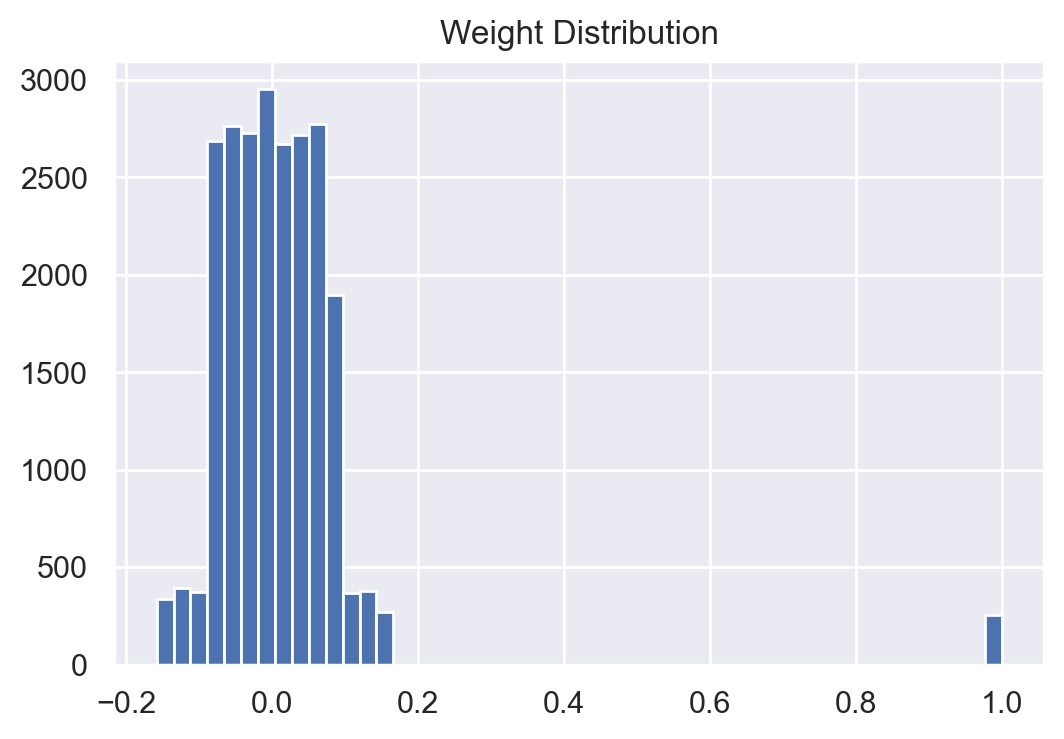

In [117]:
W = get_weights(net)
plt.figure(dpi=200)
plt.title("Weight Distribution")
plt.hist(W, bins=50)
plt.savefig("readme/fig_dist.png")
plt.show()

In [118]:
runs = []

In [119]:
for run_i in range(5):
    criterion = nn.NLLLoss()
    opt = Adam(net.parameters(), lr=1e-2)

    loss_val, acc_val, f1_val = 0, 0, 0
    all_weights = []
    train_losses, train_accs, train_f1s = [], [], []
    valid_losses, valid_accs, valid_f1s = [], [], []

    for epoch in range(EPOCHS):
        net.train()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        pbar.set_description("Run: {}/{} Epoch: {}/{}".format(
            epoch + 1, EPOCHS, run_i + 1, RUNS
        ))
        for batch_i, (train_x, train_y) in pbar:
            opt.zero_grad()

            output = net(train_x)
            loss = criterion(output, train_y)
            loss.backward()
            opt.step()
            all_weights.append(get_weights(net))

            output_y = output.max(dim=1)[1]
            acc = accuracy_score(train_y, output_y)
            f1 = f1_score(train_y, output_y, average="micro")

            loss_val = (loss_val * batch_i + loss.item()) / (batch_i + 1)
            acc_val = (acc_val * batch_i + acc) / (batch_i + 1)
            f1_val = (f1_val * batch_i + acc) / (batch_i + 1)
            train_results = {
                "loss": "{:.4f}".format(loss_val),
                "acc": "{:.2%}".format(acc_val),
                "f1": "{:.2%}".format(f1_val)
            }
            pbar.set_postfix(train_results)
        train_losses.append(loss_val)
        train_accs.append(acc_val)
        train_f1s.append(f1_val)

        loss_val, acc_val, f1_val = 0, 0, 0
        net.eval()    
        for batch_i, (valid_x, valid_y) in enumerate(valid_loader):

            with torch.no_grad():
                output = net(valid_x)
            loss = criterion(output, valid_y)

            output_y = output.max(dim=1)[1]

            acc = accuracy_score(valid_y, output_y)
            f1 = f1_score(valid_y, output_y, average="micro")

            loss_val = (loss_val * batch_i + loss.item()) / (batch_i + 1)
            acc_val = (acc_val * batch_i + acc) / (batch_i + 1)
            f1_val = (f1_val * batch_i + acc) / (batch_i + 1)
            pbar.set_postfix({
                **train_results,
                "val_loss": "{:.4f}".format(loss_val),
                "val_acc": "{:.2%}".format(acc_val),
                "val_f1": "{:.2%}".format(f1_val)
            })
        pbar.close()
        valid_losses.append(loss_val)
        valid_accs.append(acc_val)
        valid_f1s.append(f1_val)
    runs.append(all_weights)

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

In [120]:
runs2 = np.stack([np.stack(run) for run in runs])
runs2.shape

(5, 392, 23562)

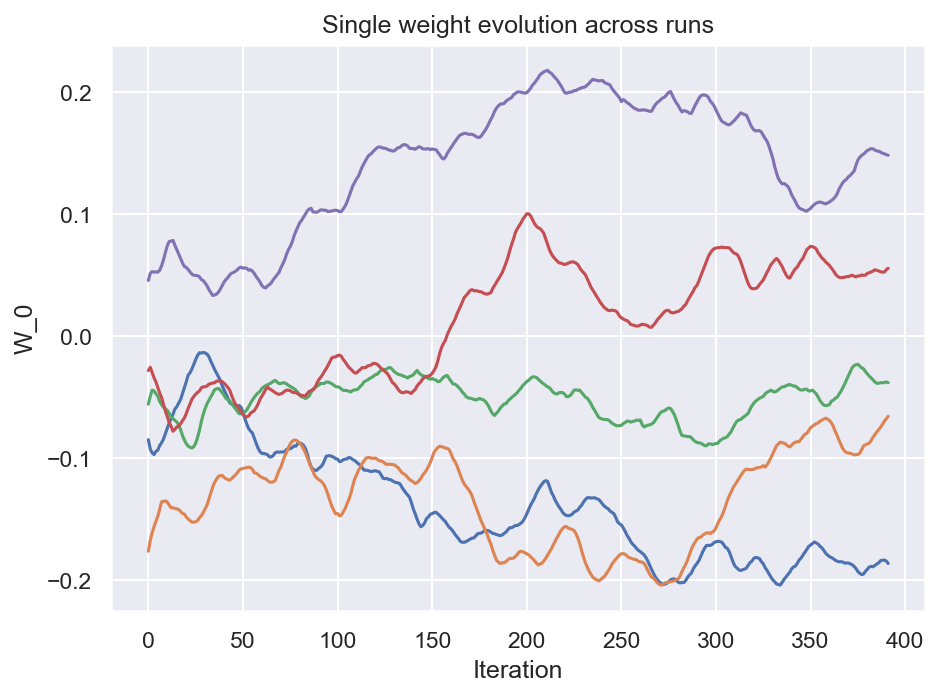

In [121]:
plt.figure(dpi=150, figsize=(7, 5))
plt.title("Single weight evolution across runs")
for i in range(RUNS):
    plt.plot(runs2[i, :, 0])
plt.xlabel("Iteration")
plt.ylabel("W_0")
plt.savefig("readme/fig_weight.png")
plt.show()

In [122]:
runs2.shape

(5, 392, 23562)

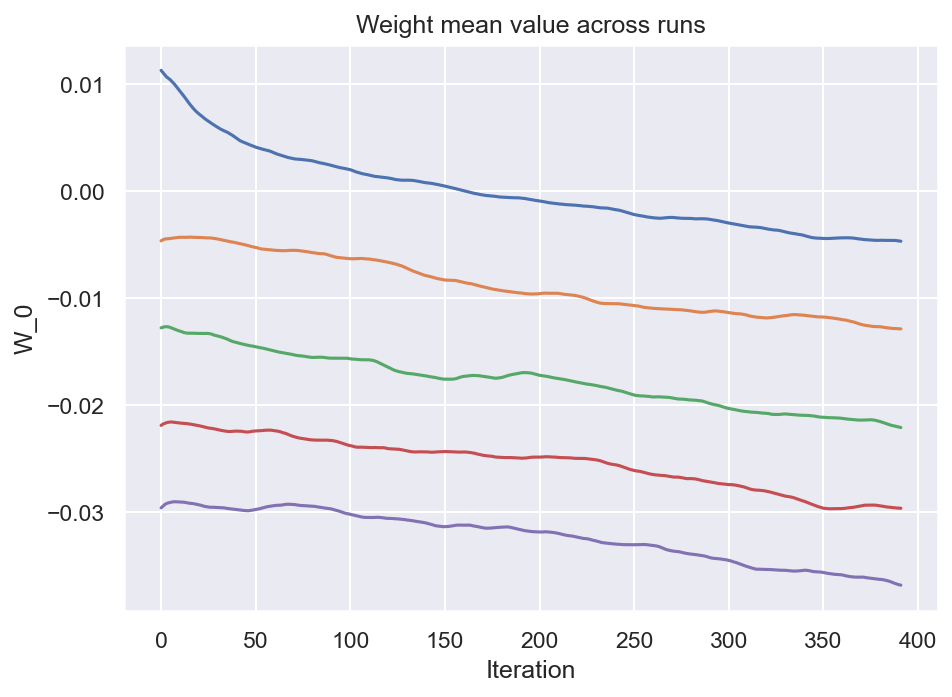

In [123]:
plt.figure(dpi=150, figsize=(7, 5))
plt.title("Weight mean value across runs")
for i in range(RUNS):
    plt.plot(runs2[i].mean(axis=1))
plt.xlabel("Iteration")
plt.ylabel("W_0")
plt.savefig("readme/fig_mean.png")
plt.show()

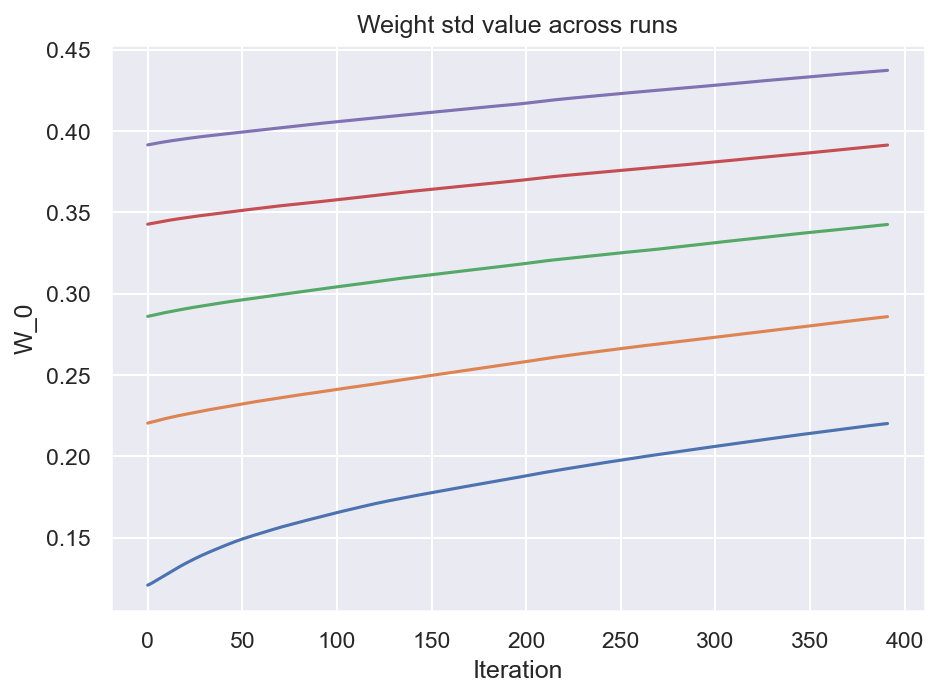

In [124]:
plt.figure(dpi=150, figsize=(7, 5))
plt.title("Weight std value across runs")
for i in range(RUNS):
    plt.plot(runs2[i].std(axis=1))
plt.xlabel("Iteration")
plt.ylabel("W_0")
plt.savefig("readme/fig_std.png")
plt.show()